In [14]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [15]:
# Load and preprocess images
def load_and_preprocess_images(data_dir, img_size=(224, 224)):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    class_map = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(class_map[class_name])
    
    images = np.array(images) / 255.0  # Normalize pixel values
    labels = np.array(labels)
    
    return images, labels, class_names

In [16]:
# Function to display one image from each class
def display_images(images, labels, class_names):
    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))
    fig.suptitle('Sample Images from Each Class', fontsize=16)

    for i, class_name in enumerate(class_names):
        # Find the first image of the current class
        idx = np.where(labels == i)[0][0]
        
        # Display the image
        axs[i].imshow(images[idx])
        axs[i].set_title(class_name)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

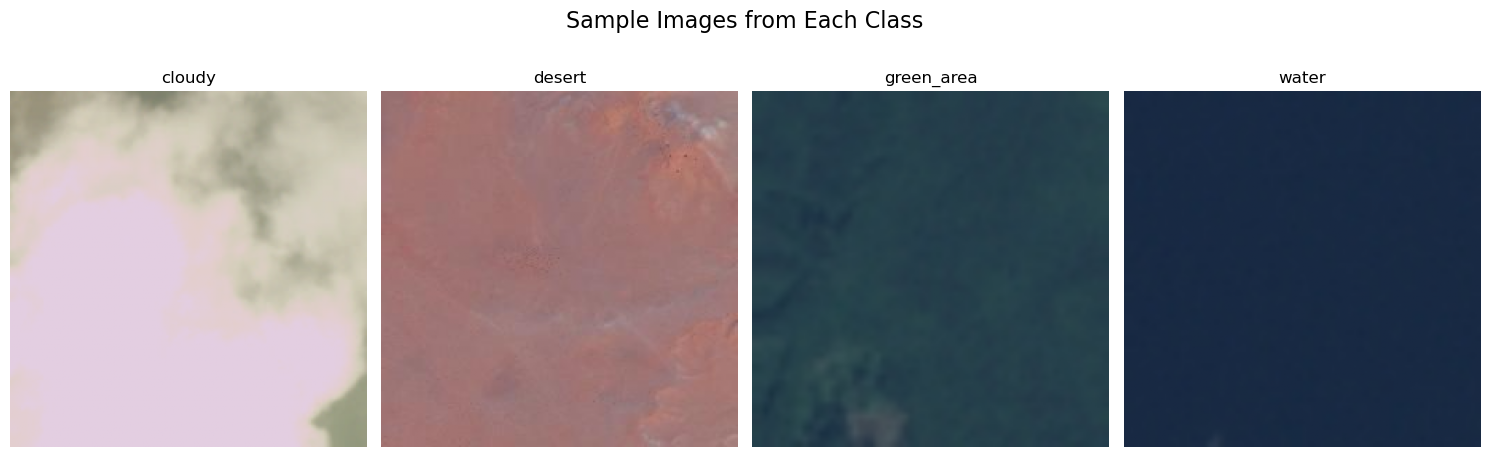

In [17]:
# Load dataset
data_dir = 'C:\\Users\\HP\\Desktop\\Fx Project\\satellite\\data\\'  # Replace with the actual path to your dataset
images, labels, class_names = load_and_preprocess_images(data_dir)

# Display one image from each class
display_images(images, labels, class_names)


In [18]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

In [19]:
# Data augmentation
train_datagen = ImageDataGenerator(
)

In [20]:
val_datagen = ImageDataGenerator()

In [21]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [22]:
# Load pretrained DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

In [24]:
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False


In [26]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Train the model
model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10


141/141 [==============================] - 172s 1s/step - loss: 0.1439 - accuracy: 0.9554 - val_loss: 0.0451 - val_accuracy: 0.9831
Epoch 2/10
141/141 [==============================] - 173s 1s/step - loss: 0.0362 - accuracy: 0.9880 - val_loss: 0.0272 - val_accuracy: 0.9920
Epoch 3/10
141/141 [==============================] - 168s 1s/step - loss: 0.0245 - accuracy: 0.9922 - val_loss: 0.0191 - val_accuracy: 0.9938
Epoch 4/10
141/141 [==============================] - 172s 1s/step - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.0227 - val_accuracy: 0.9911
Epoch 5/10
141/141 [==============================] - 168s 1s/step - loss: 0.0235 - accuracy: 0.9920 - val_loss: 0.0234 - val_accuracy: 0.9911
Epoch 6/10
141/141 [==============================] - 165s 1s/step - loss: 0.0144 - accuracy: 0.9949 - val_loss: 0.0117 - val_accuracy: 0.9965
Epoch 7/10
141/141 [==============================] - 165s 1s/step - loss: 0.0101 - accuracy: 0.9962 - val_loss: 0.0088 - val_accuracy: 0.99

In [28]:
# Evaluate the model
val_preds = model.predict(X_val)
val_preds_classes = np.argmax(val_preds, axis=1)

36/36 [==============================] - 33s 877ms/step


In [29]:
# Print classification report
print(classification_report(y_val, val_preds_classes, target_names=class_names))

              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       300
      desert       1.00      1.00      1.00       227
  green_area       0.99      0.99      0.99       300
       water       0.99      0.99      0.99       300

    accuracy                           1.00      1127
   macro avg       1.00      1.00      1.00      1127
weighted avg       1.00      1.00      1.00      1127



In [30]:
# Save the trained model
model.save('densenet_model.h5')

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
from tensorflow.keras.models import Model, load_model
# Load the trained model
loaded_model = load_model('densenet_model.h5')

In [38]:
# Function to display the input image and make predictions
def predict_and_display(img_path, model, class_names):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_normalized = img_rgb / 255.0
    img_expanded = np.expand_dims(img_normalized, axis=0)
    prediction = model.predict(img_expanded)
    predicted_class = class_names[np.argmax(prediction)]

    # Display the input image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

In [39]:
# Path to a new input image
input_image_path = 'C:\\Users\\HP\\Desktop\\Fx Project\\satellite\\data\\green_area\\Forest_42.jpg'  # Replace with the path to the input image


1/1 [==============================] - 1s 1s/step


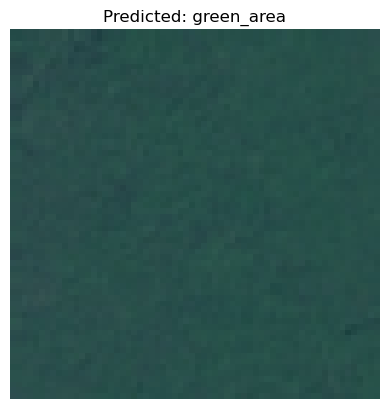

In [40]:
# Display the input image and make predictions
predict_and_display(input_image_path, loaded_model, class_names)